In [285]:
import tobac
import numpy as np
import matplotlib.pyplot as plt

import datetime
import xarray as xr

x_min, y_min, x_max, y_max, = 0, 0, 10, 10
t_max = 10
x = np.linspace(x_min, x_max, 50)
y = np.linspace(y_min, y_max, 50)

def create_wandering_blob(x_0, y_0, v_x, v_y, t_min):
    
    t = np.linspace(0, t_max, 6)
    tt, yy, xx = np.meshgrid(t, y, x, indexing='ij')

    exponent = (xx - x_0 - v_x*(tt-t_min))**2 + (yy - y_0 - v_y*(tt-t_min))**2
    blob = np.where(tt < t_min, 0, np.exp(-exponent))
    
    return blob

def create_xarray(array):

    t_0 = np.datetime64('2022-04-01T00:00')
    t_delta = np.timedelta64(1, 'm')
    time = np.array([t_0 + i*t_delta for i in range(len(array))])
    x = np.linspace(0, 10, 50)
    y = np.linspace(0, 10, 50)
    latitude = np.linspace(20, 30, 50)
    longitude = np.linspace(40, 50, 50)
    
    coords = {'time':time,
             'projection_x_coordinate':x,
             'projection_y_coordinate':y}
    
    attributes = {'units': 'm s-1'}
    
    data = xr.DataArray(data=array, 
                        coords=coords,  
                        attrs=attributes)
    return data

In [314]:
blob_1 = create_wandering_blob(0, 0, 1, 1, 0)
blob_2 = create_wandering_blob(5, 5, -1, 1, 5)
blob_mask = blob_1 > blob_2

blob = np.where(blob_mask, blob_1, blob_2)
data = create_xarray(blob)

<IPython.core.display.Javascript object>


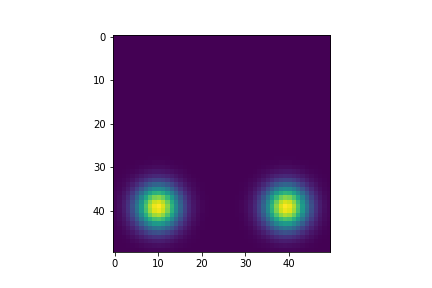

In [315]:
from matplotlib.animation import FuncAnimation
%matplotlib notebook
fig, ax = plt.subplots()

def animate(i):
    ax.imshow(data[i])
    
anim = FuncAnimation(fig, animate, frames = 6)

In [316]:
%%capture
dxy, dt = tobac.utils.get_spacings(data, grid_spacing = 1)
features = tobac.themes.tobac_v1.feature_detection_multithreshold(data, dxy, threshold=0.95)
mask, features = tobac.themes.tobac_v1.segmentation(features, data, dxy, threshold=0.5)

Frame 5: 2 trajectories present.


Text(0.5, 1.0, 'predict')

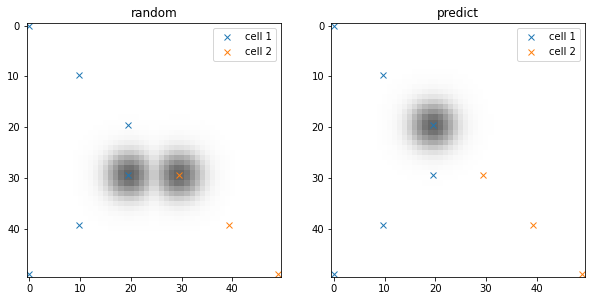

In [317]:
%matplotlib inline

track1 = tobac.themes.tobac_v1.linking_trackpy(features, 
                                              data, 
                                              dt, 
                                              dxy, 
                                              d_max=20,
                                              method_linking='random',
                                              subnetwork_size=2)

track2 = tobac.themes.tobac_v1.linking_trackpy(features, 
                                              data, 
                                              dt, 
                                              dxy, 
                                              d_max=25, 
                                              method_linking='predict',
                                              subnetwork_size=2)

fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (10, 10))

ax1.imshow(blob[3], cmap = 'Greys', alpha = 0.6)
ax2.imshow(blob[2], cmap = 'Greys', alpha = 0.6)

for i, track_i in track1.groupby('cell'):
    ax1.plot(track_i.sortby('frame')['hdim_2'], 
             track_i.sortby('frame')['hdim_1'],
            label='cell {}'.format(int(i)),
            marker ='x',
            linestyle='') 
ax1.legend()
ax1.set_title('random')

for i, track_i in track2.groupby('cell'):
    ax2.plot(track_i.sortby('frame')['hdim_2'], 
             track_i.sortby('frame')['hdim_1'],
            label='cell {}'.format(int(i)),
            marker ='x',
            linestyle='')
ax2.legend()
ax2.set_title('predict')

In [303]:
import trackpy as tp

pred = tp.predict.NearestVelocityPredict(span=1)
trajectories_unfiltered = pred.link_df(
            features.to_dataframe(),
            search_range=100,
            pos_columns=["hdim_1", "hdim_2"],
            t_column="frame",
            neighbor_strategy="KDTree",
            link_strategy="auto")

Frame 5: 2 trajectories present.


Text(0.5, 1.0, 'random')

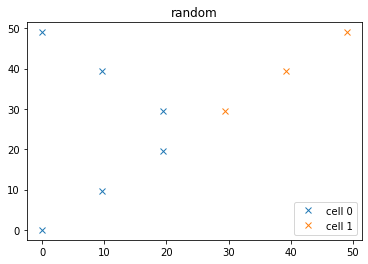

In [309]:
fig, ax1 = plt.subplots()

for i, track_i in trajectories_unfiltered.groupby('particle'):
    ax1.plot(track_i.sort_values('frame')['hdim_2'], 
             track_i.sort_values('frame')['hdim_1'],
            label='cell {}'.format(int(i)),
            marker ='x',
            linestyle='') 
ax1.legend()
ax1.set_title('random')

In [331]:
pred.observe(trajectories_unfiltered.where(trajectories_unfiltered['frame'] == 3))

AttributeError: 'NearestVelocityPredict' object has no attribute 't_column'

In [332]:
trajectories_unfiltered.where(trajectories_unfiltered['frame'] == 3)

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,projection_x_coordinate,projection_y_coordinate,ncells,particle
index,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3.0,1.0,29.5,19.5,4.0,0.95,4.0,2022-04-01 00:03:00,2022-04-01 00:03:00,6.020408,3.979592,52.0,0.0
4,3.0,2.0,29.5,29.5,4.0,0.95,5.0,2022-04-01 00:03:00,2022-04-01 00:03:00,6.020408,6.020408,52.0,1.0
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


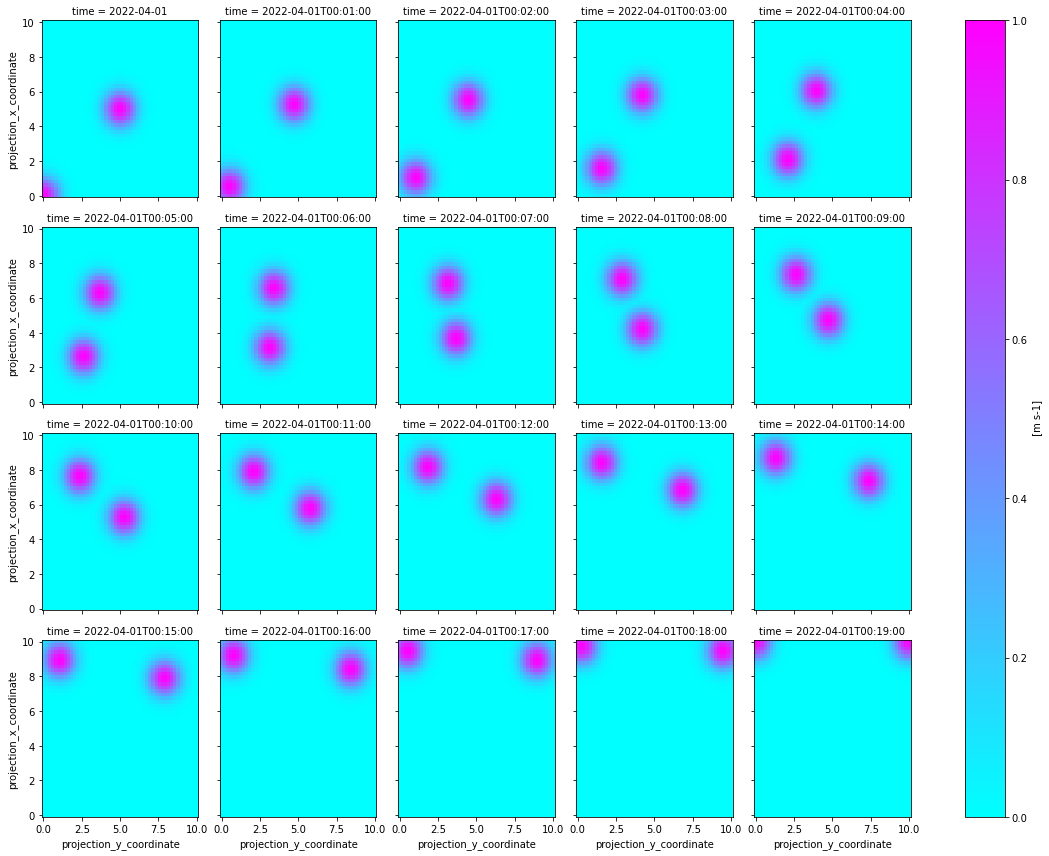

In [20]:
%matplotlib inline

data.plot(cmap = 'cool', col='time', col_wrap=5)